In [1]:
# !pip install --upgrade pip
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataset/ResearchInformation3.csv')
df


,Department,Gender,HSC,SSC,Income,Hometown,Computer,Preparation,Gaming,Attendance,Job,English,Extra,Semester,Last,Overall
0,Business Administration,Male,4.17,4.84,"Low (Below 15,000)",Village,3,More than 3 Hours,0-1 Hour,80%-100%,No,3,Yes,6th,3.220,3.350
1,Business Administration,Female,4.92,5.00,"Upper middle (30,000-50,000)",City,3,0-1 Hour,0-1 Hour,80%-100%,No,3,Yes,7th,3.467,3.467
2,Business Administration,Male,5.00,4.83,"Lower middle (15,000-30,000)",Village,3,0-1 Hour,More than 3 Hours,80%-100%,No,4,Yes,3rd,4.000,3.720
3,Business Administration,Male,4.00,4.50,"High (Above 50,000)",City,5,More than 3 Hours,More than 3 Hours,80%-100%,No,5,Yes,4th,3.800,3.750
4,Business Administration,Female,2.19,3.17,"Lower middle (15,000-30,000)",Village,3,0-1 Hour,2-3 Hours,80%-100%,No,3,Yes,4th,3.940,3.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Public Health,Male,3.50,4.00,"Lower middle (15,000-30,000)",Village,2,More than 3 Hours,2-3 Hours,40%-59%,Yes,2,Yes,7th,3.250,3.100
489,Public Health,Male,4.50,4.00,"Upper middle (30,000-50,000)",City,4,2-3 Hours,2-3 Hours,60%-79%,No,3,Yes,9th,3.500,3.670
490,Sociology,Female,4.56,3.67,"Lower middle (15,000-30,000)",City,3,0-1 Hour,2-3 Hours,40%-59%,No,2,No,2nd,3.560,3.560
491,Sociology,Male,4.23,4.50,"Low (Below 15,000)",Village,3,More than 3 Hours,2-3 Hours,80%-100%,No,3,Yes,10th,3.610,3.750


In [3]:
# Some basic EDA
df.info()
df.describe()
df.isnull().sum()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Department   493 non-null    object 
 1   Gender       493 non-null    object 
 2   HSC          493 non-null    float64
 3   SSC          493 non-null    float64
 4   Income       493 non-null    object 
 5   Hometown     493 non-null    object 
 6   Computer     493 non-null    int64  
 7   Preparation  493 non-null    object 
 8   Gaming       493 non-null    object 
 9   Attendance   493 non-null    object 
 10  Job          493 non-null    object 
 11  English      493 non-null    int64  
 12  Extra        493 non-null    object 
 13  Semester     493 non-null    object 
 14  Last         493 non-null    float64
 15  Overall      493 non-null    float64
dtypes: float64(4), int64(2), object(10)
memory usage: 61.8+ KB


Department      10
Gender           2
HSC             74
SSC             67
Income          10
Hometown         2
Computer         5
Preparation      3
Gaming           3
Attendance       4
Job              2
English          5
Extra            2
Semester        11
Last           158
Overall        128
dtype: int64

<Figure size 1500x1200 with 0 Axes>

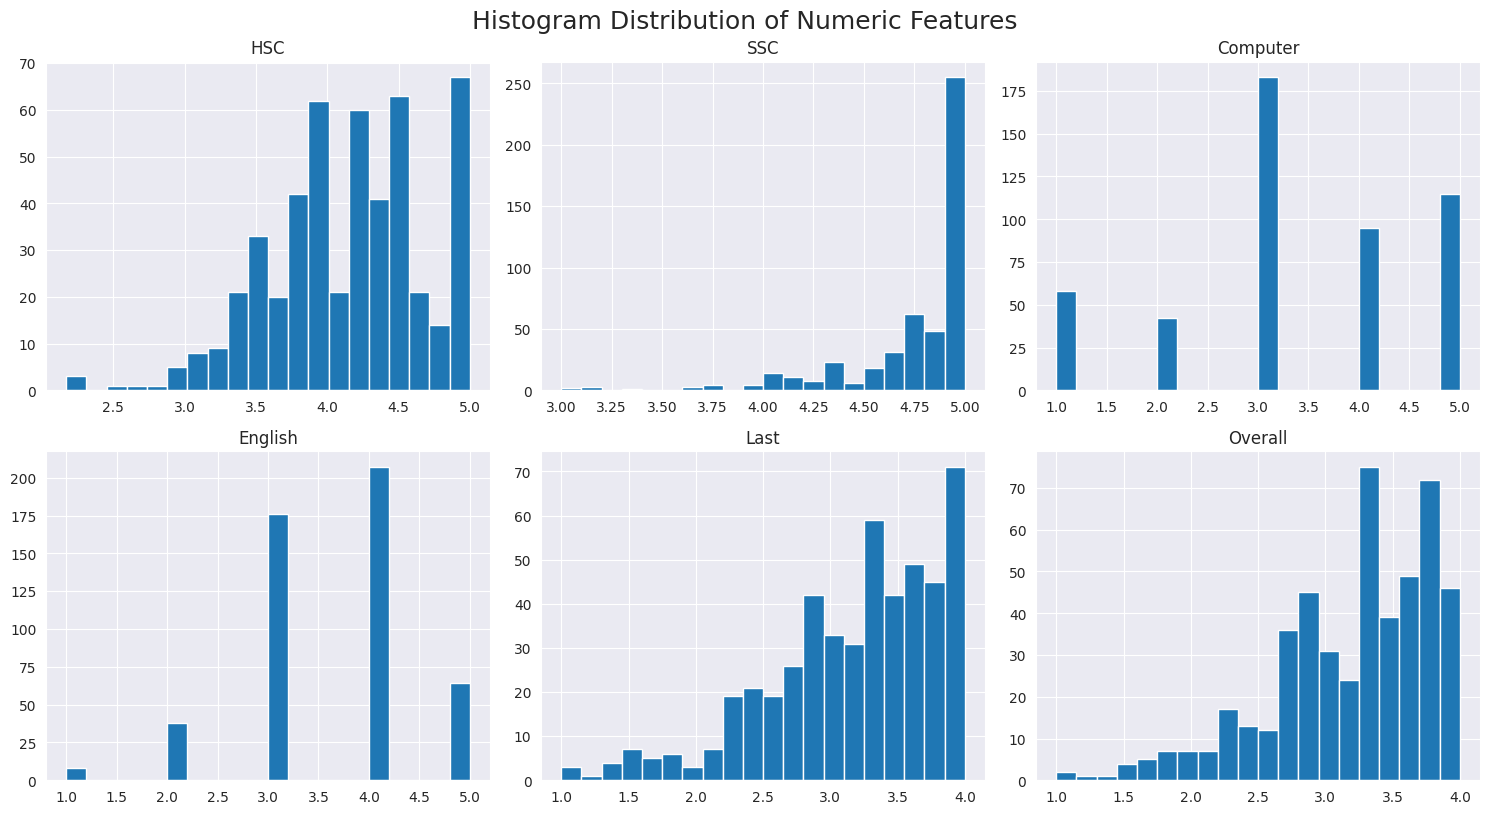

In [4]:
import numpy as np

# Histogram Plot - Numeric Feature Distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 12))
df[numeric_cols].hist(bins=20, figsize=(15, 12), layout=(len(numeric_cols)//3 + 1, 3))
plt.suptitle("Histogram Distribution of Numeric Features", fontsize=18)
plt.tight_layout()
plt.show()

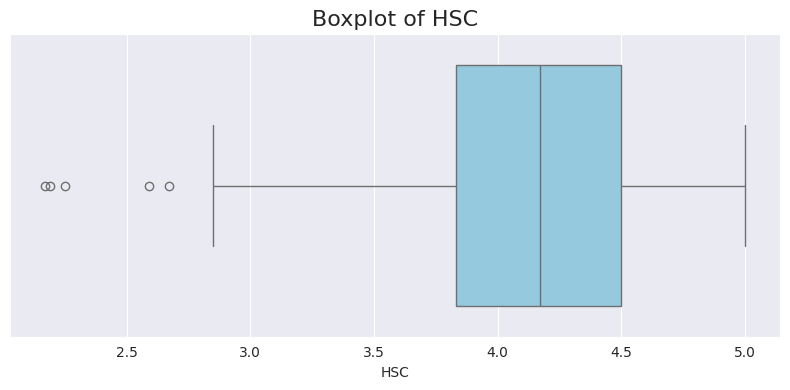

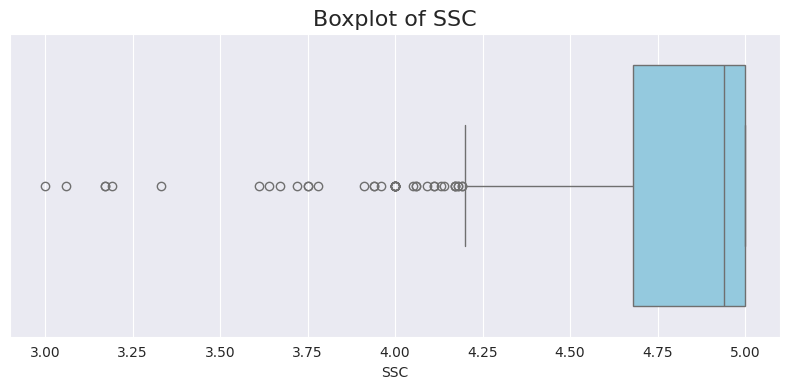

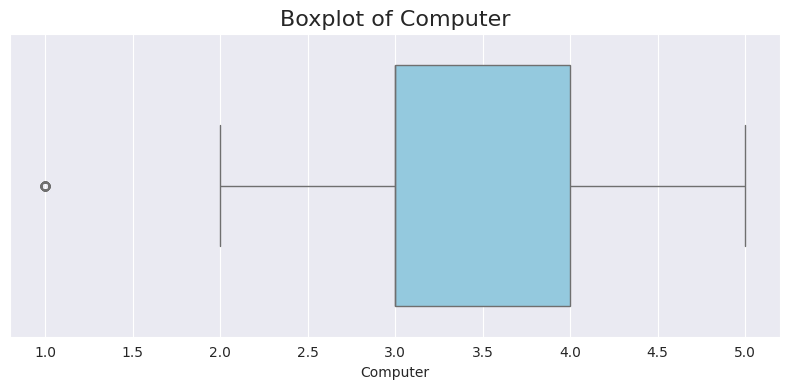

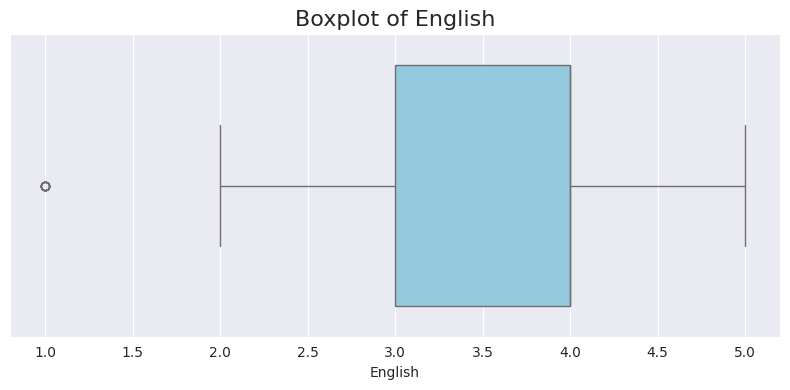

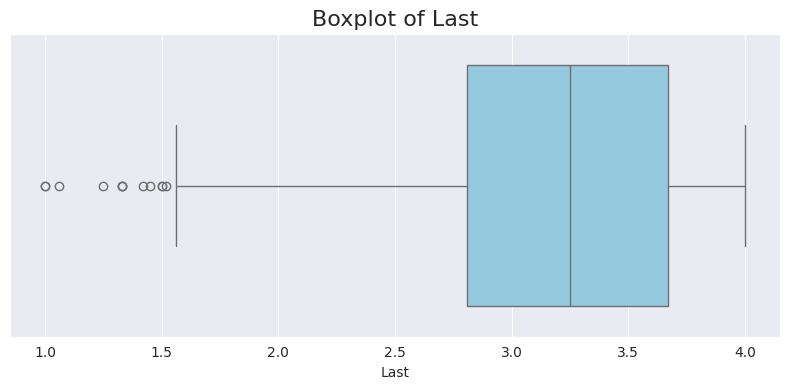

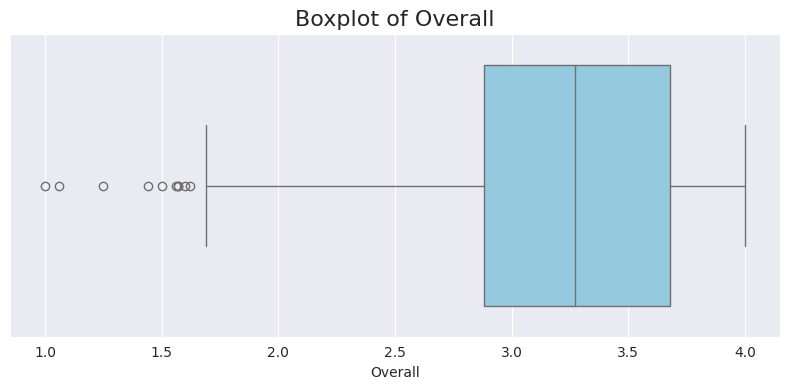

In [5]:
# Boxplot for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}", fontsize=16)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [6]:
df = df[(df["Overall"] >= 0.5) & (df["Overall"] <= 4.0)]
df = df.reset_index(drop=True)

In [7]:
df['Income'] = df['Income'].str.strip()
df['Income'] = df['Income'].str.lower()

In [8]:
numeric_cols = ['HSC', 'SSC', 'Computer', 'English']

In [9]:
prep_order = ['0-1 Hour', '2-3 Hours', 'More than 3 Hours']
semester_order = ['2nd','3rd','4th','5th','6th','7th','8th','9th','10th','11th','12th']
income_order = [
    'low (below 15,000)',
    'lower middle (15,000-30,000)',
    'upper middle (30,000-50,000)',
    'high (above 50,000)'
]
gaming_order = ['0-1 Hour', '2-3 Hours', 'More than 3 Hours']
attendance_order = ['Below 40%', '40%-59%', '60%-79%', '80%-100%']

In [10]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

ordinal_cols = ['Preparation', 'Semester', 'Income', 'Gaming', 'Attendance']
ordinal_encoder = OrdinalEncoder(
    categories=[
        prep_order,
        semester_order,
        income_order,
        gaming_order,
        attendance_order
    ]
)

encoded = ordinal_encoder.fit_transform(df[ordinal_cols])
encoded_df = pd.DataFrame(encoded, columns=ordinal_cols)
df_dropped = df.drop(ordinal_cols, axis=1)
df_merged_ordinal = pd.concat([df_dropped, encoded_df], axis=1)

dept_mean = df_merged_ordinal.groupby("Department")["Overall"].mean()
df_merged_ordinal["Department"] = df_merged_ordinal["Department"].map(dept_mean)


In [11]:
from sklearn.preprocessing import OneHotEncoder

nominal_cols = ['Gender', 'Hometown', 'Department', 'Job', 'Extra']

encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[nominal_cols])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(nominal_cols))
df_dropped = df_merged_ordinal.drop(nominal_cols, axis=1)
df_processed = pd.concat([df_dropped, encoded_df], axis=1)

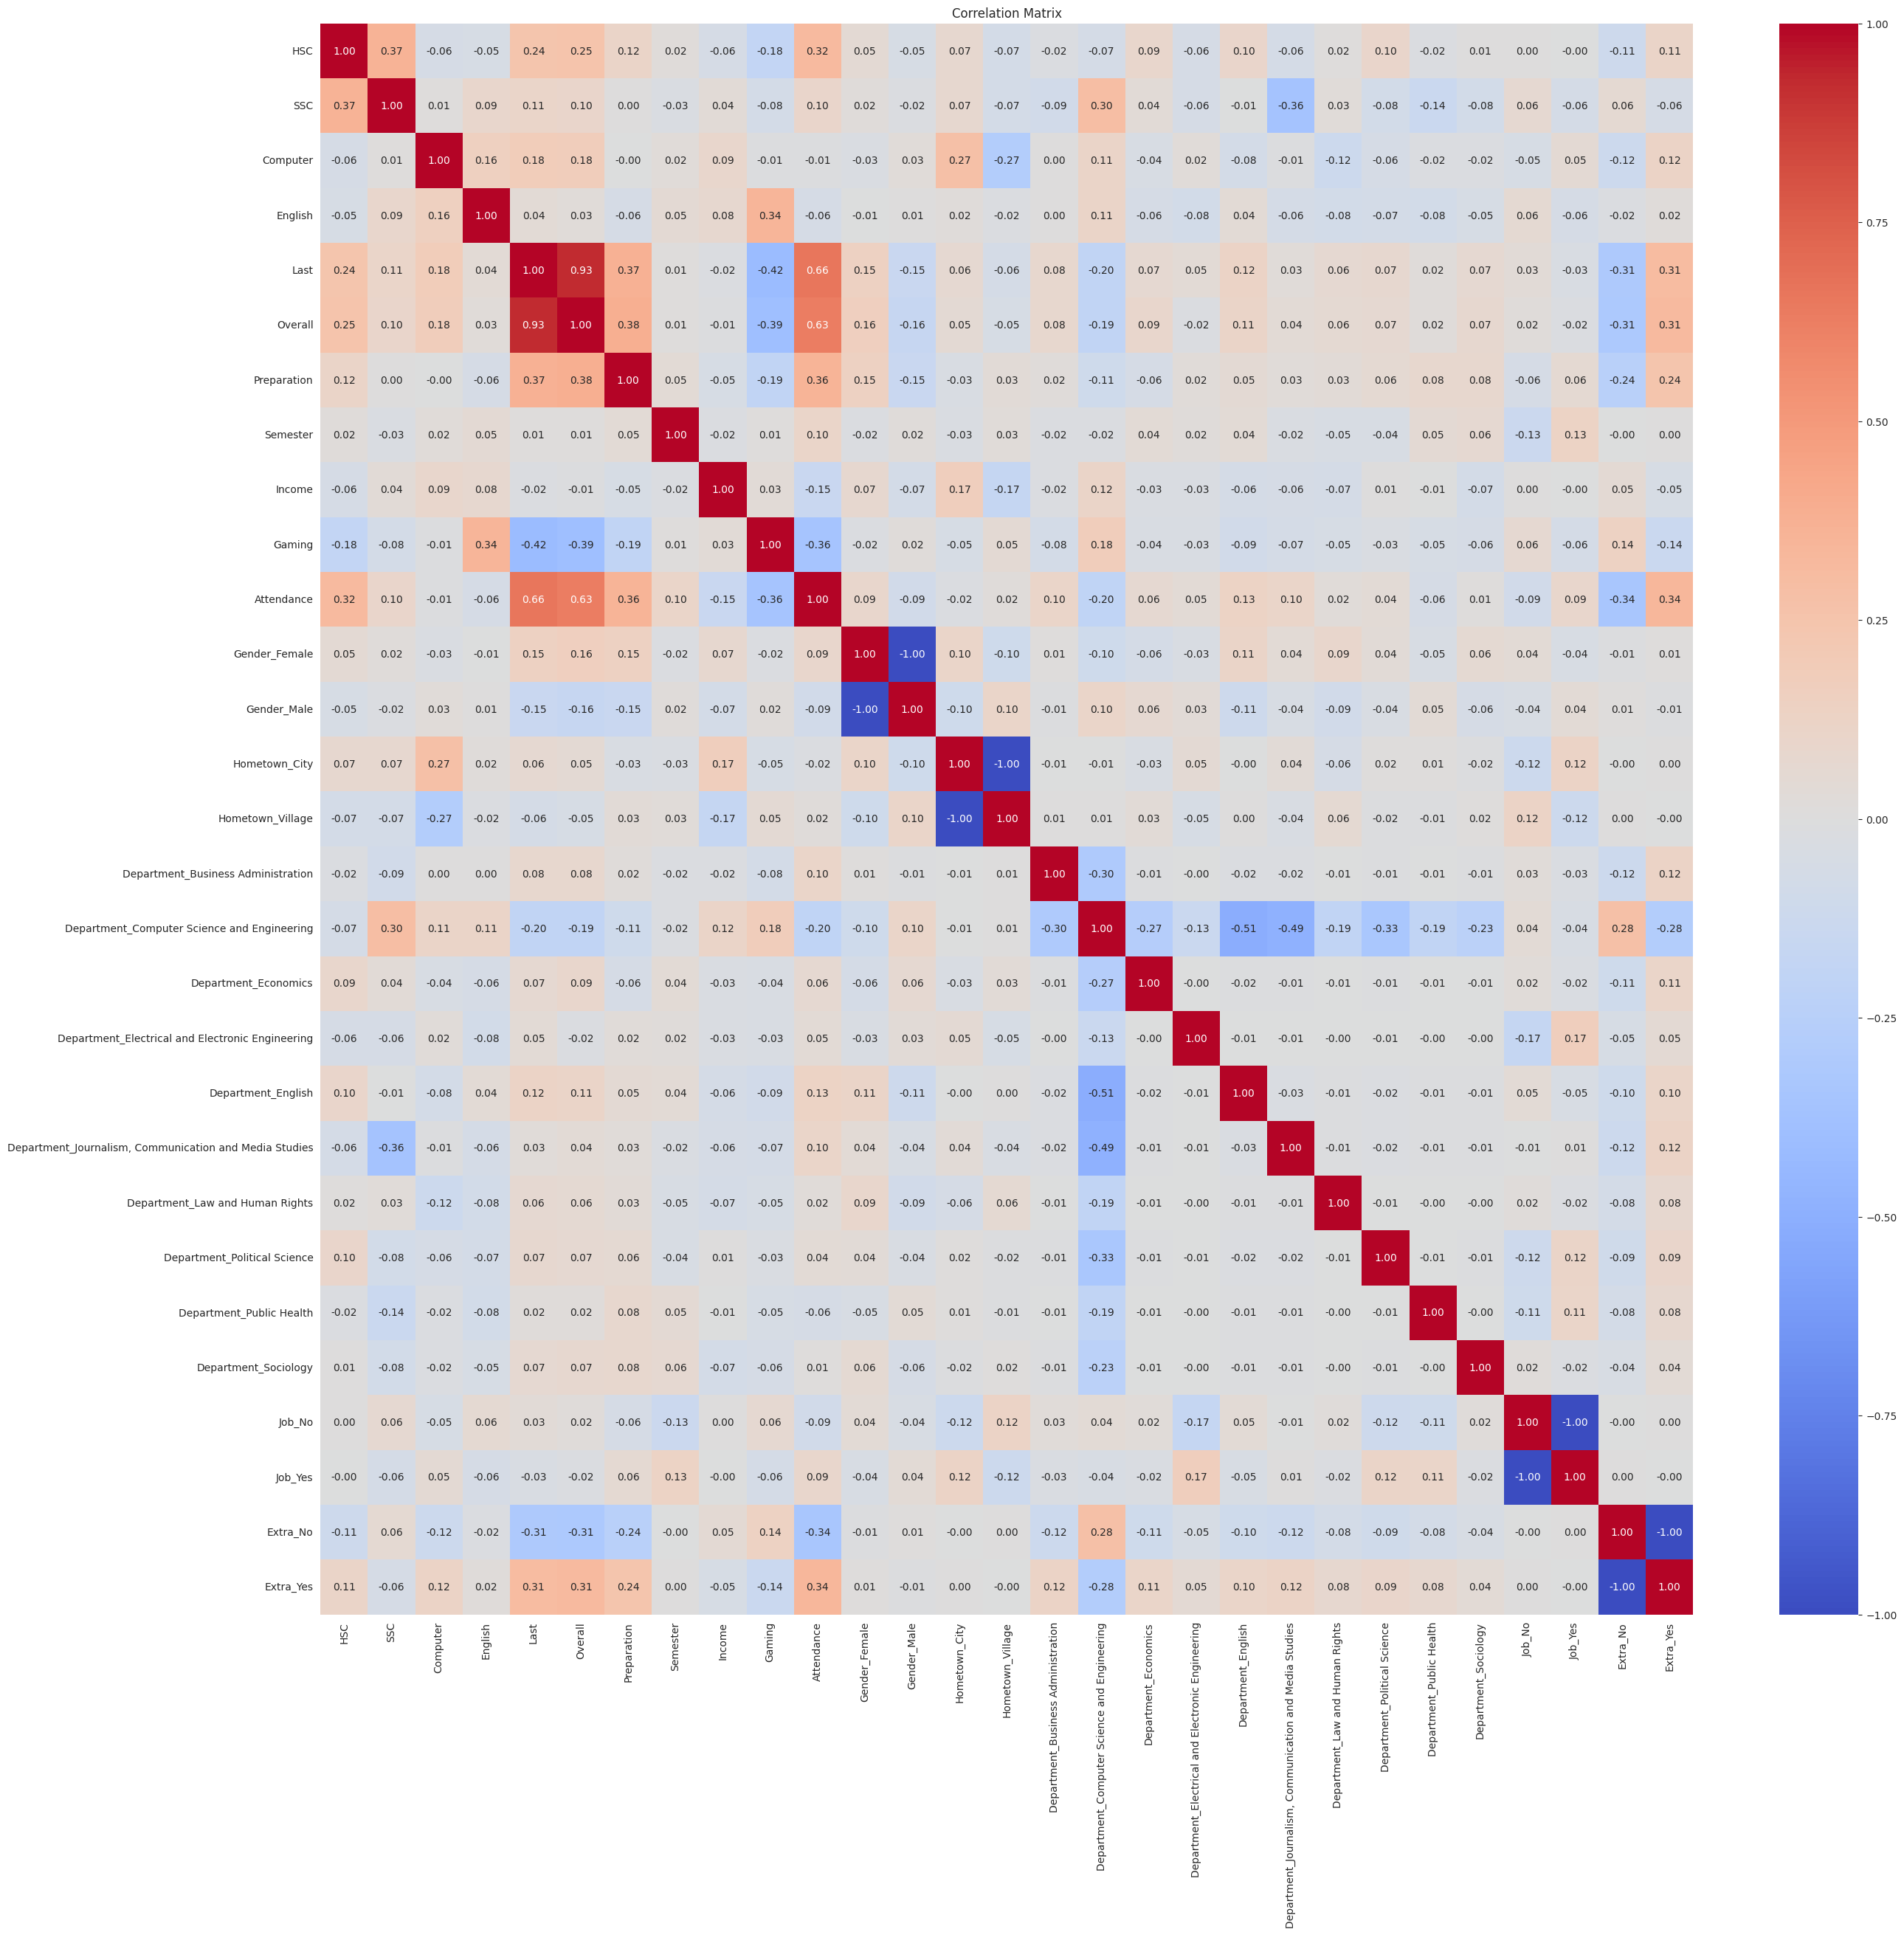

In [12]:
# 2. Compute the correlation matrix
corr = df_processed.corr(numeric_only=True)

# 3. Plot the correlation heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [13]:
target = "Overall"

# Compute correlations with target only
corr_with_target = df_processed.corr(numeric_only=True)[target].sort_values(ascending=False)
print(corr_with_target)

Overall                                                   1.000000
Last                                                      0.925076
Attendance                                                0.632471
Preparation                                               0.384053
Extra_Yes                                                 0.313666
HSC                                                       0.251960
Computer                                                  0.177536
Gender_Female                                             0.160175
Department_English                                        0.112420
SSC                                                       0.098695
Department_Economics                                      0.093184
Department_Business Administration                        0.078248
Department_Sociology                                      0.070801
Department_Political Science                              0.065390
Department_Law and Human Rights                           0.05

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = df_processed.drop('Overall', axis=1)
y = df_processed['Overall']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_scaled = scaler.fit_transform(X)

In [16]:
X = df_processed.drop('Overall', axis=1)
y = df_processed['Overall']

X_scaled = scaler.fit_transform(X)

In [17]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(f"---- {name} ----")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print()

evaluate(model_lr, "Linear Regression")
evaluate(model_svm, "SVM Regression")
evaluate(model_dt, "Decision Tree Regression")

NameError: name 'model_lr' is not defined

Feature Importances:
Attendance: 0.3640
Preparation: 0.2002
English: 0.0729
Semester: 0.0626
HSC: 0.0604
Computer: 0.0575
SSC: 0.0471
Income: 0.0276
Gaming: 0.0236
Department_Computer Science and Engineering: 0.0233
Hometown_Village: 0.0086
Extra_Yes: 0.0080
Gender_Male: 0.0070
Hometown_City: 0.0066
Extra_No: 0.0065
Gender_Female: 0.0063
Department_Journalism, Communication and Media Studies: 0.0050
Job_Yes: 0.0033
Job_No: 0.0033
Department_Economics: 0.0019
Department_Law and Human Rights: 0.0011
Department_Sociology: 0.0010
Department_English: 0.0010
Department_Electrical and Electronic Engineering: 0.0007
Department_Business Administration: 0.0002
Department_Political Science: 0.0002
Department_Public Health: 0.0001
